In [17]:
import os
import sys
import pandas as pd
import shutil
from goatools import obo_parser
from dotenv import load_dotenv, find_dotenv
from transformers import AutoTokenizer, AutoModel
import torch
from collections import defaultdict
import random
import re
from networkx.drawing.nx_agraph import graphviz_layout

sys.path.append('../src/CandiNet')

import utils

## Load Files

In [2]:
# Load geneid to uniprot id mapping
try:
    geneid_to_uniprot = torch.load('../data/geneid_to_uniprot.pt')
    print('loaded geneid_to_uniprot mapping')
except:
    print(f'geneid_to_uniprot not found, creating new one')
    geneid_to_uniprot = {}
    pass

# Load embeddings
go_embeddings = torch.load("../data/go_term_embeddings.pt", weights_only=False)
esm_embeddings = torch.load("../../NullEffectNet/data/esm/large_esm_uniprot_to_embedding_dictionary.pt")
print('loaded embeddings')

# Load gene2go
gene2go = pd.read_csv("../../decode-agent/data/gene2go_human.tsv", sep="\t")
gene2go = gene2go[["GeneID", "GO_ID"]]
print('loaded gene2go')

# Load UniProt mapping
idmap = pd.read_csv("../../decode-agent/data/HUMAN_9606_idmapping.dat", sep="\t", header=None, names=["GeneID", "ID_Type", "ID_Value"])
print('loaded idmap')

# Load GO df
go_df = utils.load_go_df()
print('loaded go df')

data = torch.load('../data/data.pt')
print('loaded data')

loaded geneid_to_uniprot mapping
loaded embeddings
loaded gene2go
loaded idmap
../data/go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms; optional_attrs(def)
loaded go df
loaded data


## Split Dataset

In [3]:
def has_grandparents(term):
    if term not in go_relations:
        return False
    
    # Get parents of the term
    parents = go_relations[term]['parents']
    
    # Check if any parent has parents (grandparents of original term)
    for parent in parents:
        if parent in go_relations and go_relations[parent]['parents']:
            return True
    
    return False

# Create a dictionary mapping each GO term to its parents and children
go_relations = {}
for _, row in go_df.iterrows():
    go_id = row['go_id']
    parents = row['parents']  # Already a list
    children = row['children']  # Already a list
    go_relations[go_id] = {'parents': parents, 'children': children}

# only molecular function
go_df = go_df[go_df['namespace'] == 'molecular_function']

# no obselete terms
go_df = go_df[go_df['is_obsolete'] == False]
go_df['has_grandparents'] = go_df['go_id'].apply(has_grandparents)
go_df

,go_id,name,namespace,definition,is_obsolete,parents,children,has_grandparents
2,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...",False,[GO:0005385],[],True
3,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",False,[GO:0005385],[],True
4,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...",False,[GO:0000030],"[GO:0052917, GO:0033164]",True
5,GO:0000010,heptaprenyl diphosphate synthase activity,molecular_function,"""Catalysis of the reaction: (2E,6E)-farnesyl d...",False,[GO:0120531],[],True
8,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,molecular_function,"""Catalysis of the hydrolysis of ester linkages...",False,[GO:0004520],"[GO:1990599, GO:1990601]",True
...,...,...,...,...,...,...,...,...
43517,GO:0043851,[methyl-Co(III) methanol-specific corrinoid pr...,molecular_function,"""Catalysis of the reaction: a [methyl-Co(III) ...",False,[GO:0008168],[],True
43519,GO:1990301,cellulosome binding,molecular_function,"""Binding to a cellulosome, an extracellular mu...",False,[GO:0005488],[],True
43534,GO:0061636,ubiquitin ligase activator activity,molecular_function,"""Binds to and increases the activity of a ubiq...",False,[GO:0097027],[],True
43538,GO:0061637,ubiquitin ligase inhibitor activity,molecular_function,"""Binds to and stops, prevents or reduces the a...",False,[GO:0055105],[],True


In [4]:
go_df = go_df[go_df['has_grandparents'] == True]
go_df

,go_id,name,namespace,definition,is_obsolete,parents,children,has_grandparents
2,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...",False,[GO:0005385],[],True
3,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",False,[GO:0005385],[],True
4,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,"""Catalysis of the transfer of a mannose residu...",False,[GO:0000030],"[GO:0052917, GO:0033164]",True
5,GO:0000010,heptaprenyl diphosphate synthase activity,molecular_function,"""Catalysis of the reaction: (2E,6E)-farnesyl d...",False,[GO:0120531],[],True
8,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,molecular_function,"""Catalysis of the hydrolysis of ester linkages...",False,[GO:0004520],"[GO:1990599, GO:1990601]",True
...,...,...,...,...,...,...,...,...
43517,GO:0043851,[methyl-Co(III) methanol-specific corrinoid pr...,molecular_function,"""Catalysis of the reaction: a [methyl-Co(III) ...",False,[GO:0008168],[],True
43519,GO:1990301,cellulosome binding,molecular_function,"""Binding to a cellulosome, an extracellular mu...",False,[GO:0005488],[],True
43534,GO:0061636,ubiquitin ligase activator activity,molecular_function,"""Binds to and increases the activity of a ubiq...",False,[GO:0097027],[],True
43538,GO:0061637,ubiquitin ligase inhibitor activity,molecular_function,"""Binds to and stops, prevents or reduces the a...",False,[GO:0055105],[],True


In [6]:
go_ids = list(go_df['go_id'])

In [11]:
def create_holdout_sets(go_ids, go_df, target_size=100):
    
    # Find all leaf nodes (terms with no children)
    leaf_nodes = [go_id for go_id in go_ids 
                 if go_id in go_relations and len(go_relations[go_id]['children']) == 0]
    
    # Function to build a cluster of closely related terms
    def build_cluster(seed_term, available_terms, max_size):
        cluster = [seed_term]
        visited = {seed_term}
        queue = [seed_term]  # For BFS
        
        while queue and len(cluster) < max_size:
            current = queue.pop(0)
            
            # Get immediate relatives (only direct parents and children)
            if current in go_relations:
                immediate_relatives = go_relations[current]['parents'] + go_relations[current]['children']
                
                for relative in immediate_relatives:
                    if relative in available_terms and relative not in visited:
                        visited.add(relative)
                        cluster.append(relative)
                        queue.append(relative)
                        
                        if len(cluster) >= max_size:
                            break
        
        return cluster
    
    # Create two holdout sets
    available_terms = set(go_ids)
    available_leaf_nodes = set(leaf_nodes)
    holdout1 = []
    holdout2 = []
    
    # Create first holdout set
    while len(holdout1) < target_size and available_leaf_nodes:
        if not available_leaf_nodes:
            break
            
        seed_term = random.choice(list(available_leaf_nodes))
        available_leaf_nodes.remove(seed_term)
        
        # Build a cluster of closely related terms
        remaining_slots = target_size - len(holdout1)
        cluster = build_cluster(seed_term, available_terms, remaining_slots)
        
        # Add to holdout1
        holdout1.extend(cluster)
        
        # Remove these terms from available terms and leaf nodes
        cluster_set = set(cluster)
        available_terms -= cluster_set
        available_leaf_nodes -= cluster_set
    
    # Create second holdout set
    while len(holdout2) < target_size and available_leaf_nodes:
        if not available_leaf_nodes:
            break
            
        seed_term = random.choice(list(available_leaf_nodes))
        available_leaf_nodes.remove(seed_term)
        
        # Build a cluster of closely related terms
        remaining_slots = target_size - len(holdout2)
        cluster = build_cluster(seed_term, available_terms, remaining_slots)
        
        # Add to holdout2
        holdout2.extend(cluster)
        
        # Remove these terms from available terms and leaf nodes
        cluster_set = set(cluster)
        available_terms -= cluster_set
        available_leaf_nodes -= cluster_set
    
    # Training set is everything else
    training_set = list(set(go_ids) - set(holdout1) - set(holdout2))
    
    print(f"Holdout set 1 size: {len(holdout1)}")
    print(f"Holdout set 2 size: {len(holdout2)}")
    print(f"Training set size: {len(training_set)}")
    
    return holdout1, holdout2, training_set

test_set, val_set, train_set = create_holdout_sets(go_ids, go_df, target_size=500)

Holdout set 1 size: 500
Holdout set 2 size: 500
Training set size: 10188


In [12]:
test_go_df = go_df[go_df['go_id'].isin(test_set)]
test_go_df

,go_id,name,namespace,definition,is_obsolete,parents,children,has_grandparents
31,GO:0000048,peptidyltransferase activity,molecular_function,"""Catalysis of the reaction: peptidyl-tRNA(1) +...",False,"[GO:0140096, GO:0016755, GO:0140101]",[],True
129,GO:0000215,tRNA 2'-phosphotransferase activity,molecular_function,"""Catalysis of the reaction: 2'-phospho-[ligate...",False,"[GO:0016773, GO:0140101]",[],True
175,GO:0000285,1-phosphatidylinositol-3-phosphate 5-kinase ac...,molecular_function,"""Catalysis of the reaction: a 1-phosphatidyl-1...",False,[GO:0052742],[],True
445,GO:0000823,"inositol-1,4,5-trisphosphate 6-kinase activity",molecular_function,"""Catalysis of the reaction: 1D-myo-inositol 1,...",False,[GO:0051766],[],True
446,GO:0000824,"inositol-1,4,5,6-tetrakisphosphate 3-kinase ac...",molecular_function,"""Catalysis of the reaction: 1D-myo-inositol 1,...",False,[GO:0051765],[],True
...,...,...,...,...,...,...,...,...
33398,GO:0160236,tRNA 5-taurinomethyluridine synthase activity,molecular_function,"""Catalysis of the reaction: 5,10-methylenetetr...",False,"[GO:0016740, GO:0140101]",[],True
33497,GO:0180030,inositol phosphate kinase activity,molecular_function,"""Catalysis of the reaction: inositol phosphate...",False,[GO:0016301],"[GO:0000827, GO:0000828, GO:0051765, GO:005176...",True
38510,GO:1990244,histone H2AT120 kinase activity,molecular_function,"""Catalysis of the reaction: histone H2A-threon...",False,"[GO:0004674, GO:0140995]",[],True
38625,GO:1990404,NAD+-protein mono-ADP-ribosyltransferase activity,molecular_function,"""Catalysis of the reaction: amino acyl-[protei...",False,"[GO:0140096, GO:0016763]","[GO:0140808, GO:0106274, GO:0140802, GO:014080...",True


In [13]:
go_relations

{'GO:0000001': {'parents': ['GO:0048308', 'GO:0048311'], 'children': []},
 'GO:0000002': {'parents': ['GO:0007005'], 'children': []},
 'GO:0000006': {'parents': ['GO:0005385'], 'children': []},
 'GO:0000007': {'parents': ['GO:0005385'], 'children': []},
 'GO:0000009': {'parents': ['GO:0000030'],
  'children': ['GO:0052917', 'GO:0033164']},
 'GO:0000010': {'parents': ['GO:0120531'], 'children': []},
 'GO:0000011': {'parents': ['GO:0007033', 'GO:0048308'], 'children': []},
 'GO:0000012': {'parents': ['GO:0006281'],
  'children': ['GO:1903823', 'GO:1990396']},
 'GO:0000014': {'parents': ['GO:0004520'],
  'children': ['GO:1990599', 'GO:1990601']},
 'GO:0000015': {'parents': ['GO:1902494'], 'children': []},
 'GO:0000016': {'parents': ['GO:0004553'], 'children': []},
 'GO:0000017': {'parents': ['GO:0042946'], 'children': []},
 'GO:0000018': {'parents': ['GO:0051052'],
  'children': ['GO:1903110',
   'GO:0010569',
   'GO:0010520',
   'GO:0000019',
   'GO:0072695',
   'GO:0061806',
   'GO:0045

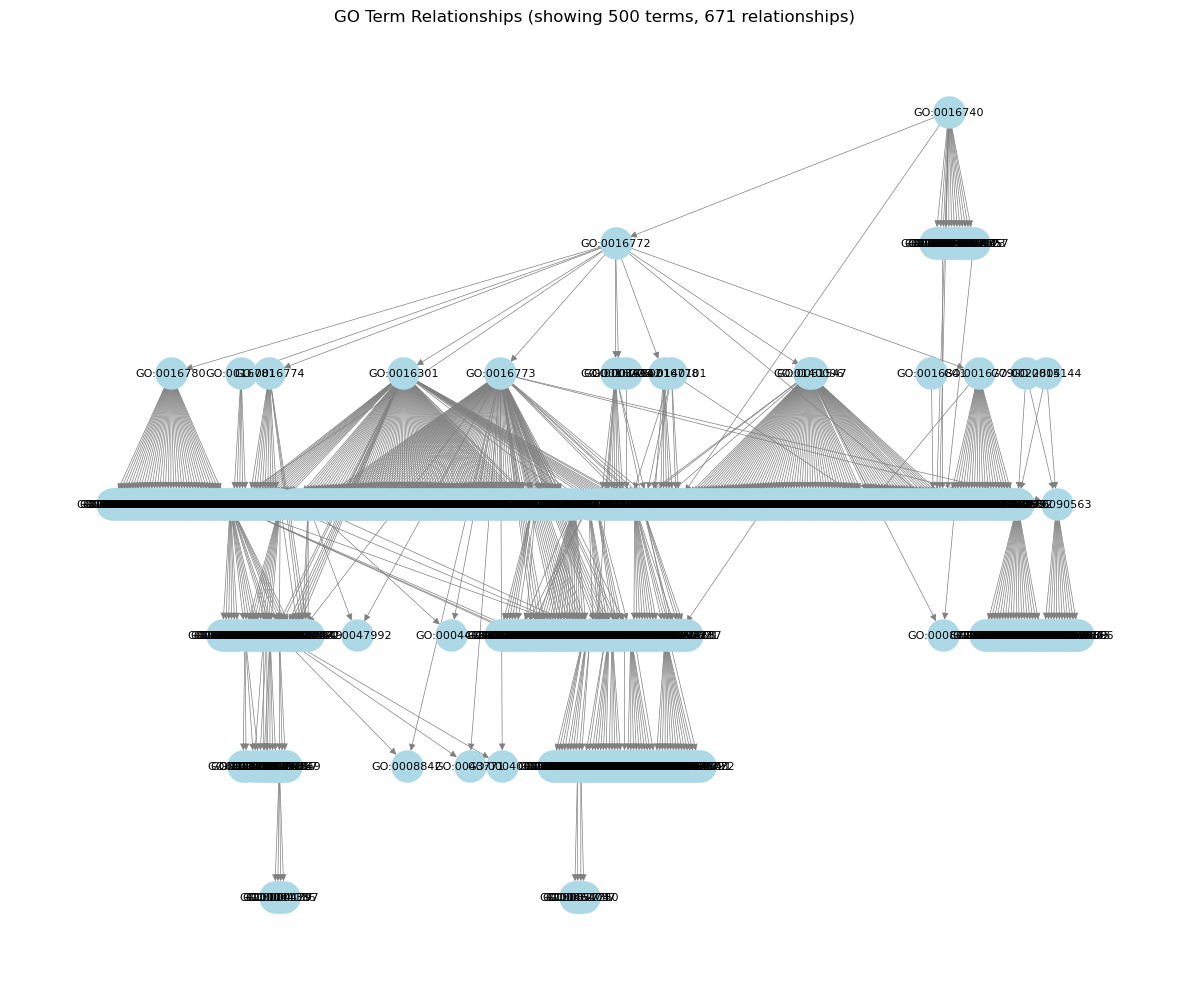

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_go_graph(go_relations, max_terms=50):
    """
    Create a visual graph representation of GO terms and their relationships.
    Limits to max_terms to keep the visualization manageable.
    
    Args:
        go_relations: The dictionary mapping GO terms to their parents and children
        max_terms: Maximum number of terms to include in the visualization
    """
    G = nx.DiGraph()
    
    # Add a limited number of terms to keep the graph readable
    terms_to_add = list(go_relations.keys())[:max_terms]
    
    # Add edges (parent -> child relationships)
    edges_added = 0
    for term in terms_to_add:
        # Add the term as a node
        G.add_node(term)
        
        # Add edges to children
        for child in go_relations[term]['children']:
            if child in terms_to_add:
                G.add_edge(term, child)
                edges_added += 1
    
    # Set up the plot
    plt.figure(figsize=(12, 10))
    plt.title(f"GO Term Relationships (showing {len(terms_to_add)} terms, {edges_added} relationships)")
    
    # Use a hierarchical layout
    #pos = nx.spring_layout(G, seed=42)
    pos=graphviz_layout(G, prog='dot')
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=8, arrows=True, 
            edge_color='gray', width=0.5)
    
    plt.tight_layout()
    plt.show()

visualize_go_graph({id:go_relations[id] for id in test_set}, max_terms=500)